# Waterloo, Water Lilies: Using GAN to Generate a Monet-Style Painting

CU Boulder MSDS

DTSA 5511 Week 5

# 1. Introduction

The purpose of this project is to build a GAN to generate Monet-style paintings from images and then appropriately trick a classifier into saying those are actually Monet paintings. So here we are, attempting to forge classic works of art. Not exactly what I thought I'd be doing this week, but oh well.

Our dataset consists of four directories:
* monet_tfrec/monet_jpeg -- these contain 300 images of Monet's paintings (256x256 pixels)
* photo_tfrec/photo_jpg -- these contain 7028 random photos (256x256 pixels)

Note: the organizers of this competition suggest using the TFRecords format of the images instead of the JPEGs, so that is what I am going to do.

We'll be using the Monet paintings to train our model. The output for submission is a .zip file containing between 7,000-10,000 256x256 pixel images which certainly _look_ like Monets. The evaluation is based on MiFID (Memorization-informed Frechet Inception Distance), which is a modified form of Frechet Inception Distance (FID). This is a standard evaluation method for GANs.

In [1]:
# Importing some classes!

# The basics
import numpy as np
import os, time, gc, io, shutil, zipfile, PIL
import warnings

# plotting
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


warnings.filterwarnings('ignore')

2025-06-18 20:27:40.167476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750278460.361975      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750278460.418056      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define setup strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:',tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

autotune = tf.data.experimental.AUTOTUNE
print(tf.__version__)

Number of replicas: 1
2.18.0


# 2. Dealing with the Data

## 2.1 Load the TFRecord Files

In [3]:
monetFiles = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')

photoFiles = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

print('Monet TFRecord Files:', len(monetFiles))
print('Photo TFRecord Files:', len(photoFiles))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
# Now we need to load & decode the dataset, because even though there 
# are only Monet 5 TFRecord files, there are 300 images inside them.
def decodeImage(img):
    # Convert a compressed image to a float tensor with scaled values in [-1, 1]
    img = tf.image.decode_jpeg(img,channels=3) # these are RGB
    img = (tf.cast(img,tf.float32)/127.5)-1
    img = tf.reshape(img,[*imgSize,3])
    return img

def readTFRecord(rec):
    # Extract an image from the TFRecord file
    tfrecord_format = {
        'image_name': tf.io.FixedLenFeature([],tf.string),
        'image': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.string)
    }
    rec = tf.io.parse_single_example(rec,tfrecord_format)
    img = decodeImage(rec['image'])
    return img

def loadDataset(filenames, batchSize = 1):
    # Load and prepare the TFRecord dataset
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(readTFRecord, num_parallel_calls = autotune)
    dataset = dataset.batch(batchSize)
    dataset = dataset.cache()
    dataset = dataset.prefetch(autotune)
    return dataset

In [5]:
# Time to read in the dataset
imgSize = [256, 256]

monetDat = loadDataset(monetFiles,1)
photoDat = loadDataset(photoFiles,1)

# Ta-da!

I0000 00:00:1750278475.174641      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## 2.2 The Actual Exploratory Data Analysis

In [6]:
# Let's visualize a painting and photo!
def seePics(monet,photo):
    plt.figure(figsize=(10,10))

    plt.subplot(1,2,1)
    plt.title('Monet')
    plt.imshow(monet[0]*0.5 + 0.5)

    plt.subplot(1,2,2)
    plt.title('Photo')
    plt.imshow(photo[0]*0.5 + 0.5)

    plt.show()

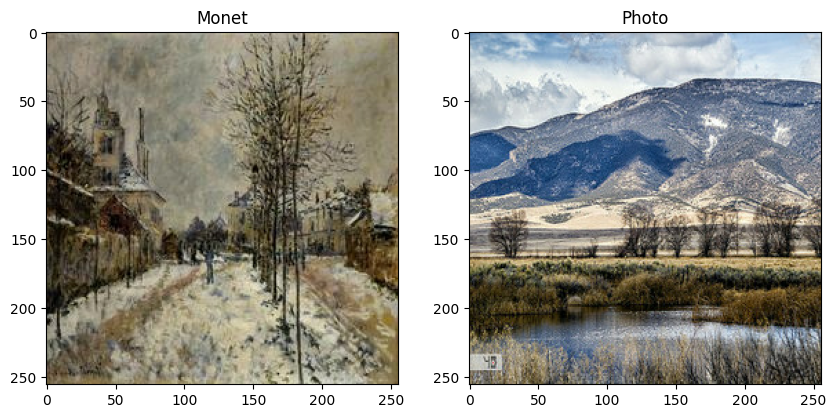

In [7]:
monetEx = next(iter(monetDat))
photoEx = next(iter(photoDat))

seePics(monetEx, photoEx)
# Gorgeous. Hey, is that photo of Colorado?

In [8]:
# Now let's look at the RGB color distribution in these photos.
def seeRGBVals(img, title):
    # rescale our images back to [0, 255]
    img = ((img[0]*0.5 + 0.5)*255).numpy().astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1)
    plt.title(title)
    plt.imshow(img)

    colours = ['red','green','blue']
    for ii, colour in enumerate(colours):
        plt.subplot(1,4,ii+2)
        plt.title(f'{colour.capitalize()} Channel')
        plt.hist(img[:,:,ii].flatten(), bins=50, color=colour,alpha=0.7)
        plt.xlim([0,255])

    plt.tight_layout()
    plt.show()

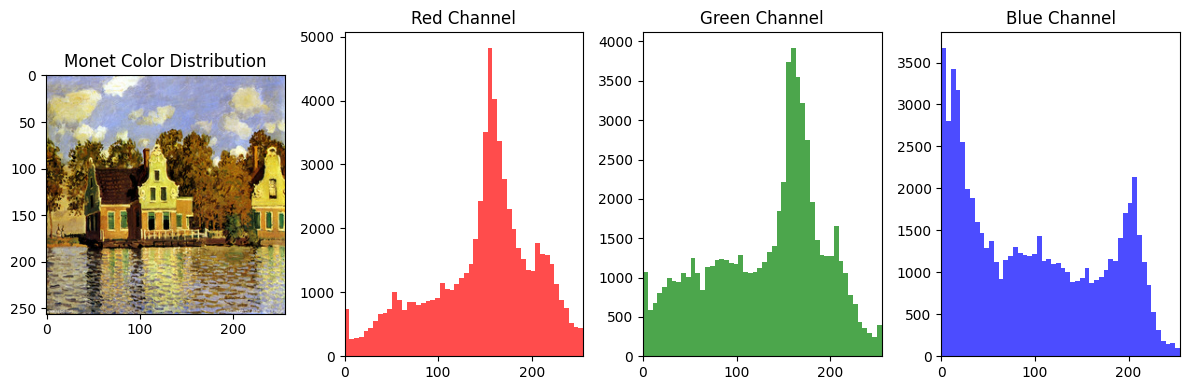

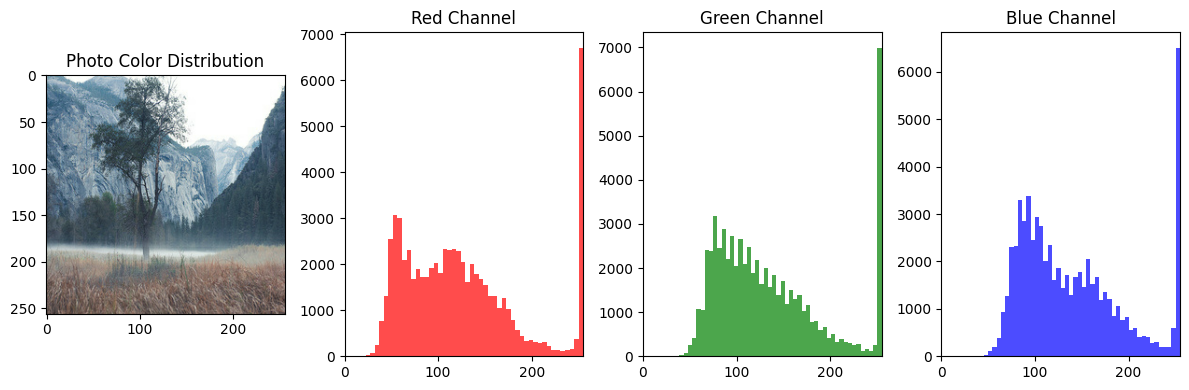

In [9]:
monetRand = monetDat.shuffle(buffer_size=100)
photoRand = photoDat.shuffle(buffer_size=100)

monetEx2 = next(iter(monetRand))
photoEx2 = next(iter(photoRand))
seeRGBVals(monetEx2,'Monet Color Distribution')
seeRGBVals(photoEx2,'Photo Color Distribution')

## Exploratory Data Analysis Conclusions

In general, it's fairly easy for the human eye to distinguish between a painting (especially an Impressionist painting, like a Monet) and a photograph. The Impressionist painting style was all about giving the _impression_ of an object or landscape rather than accuracy, which is the hallmark of a photograph. Thus Monet's paintings have visible color gradients & rougher color transitions, visible brushstrokes, and softer tones as if you're seeing the image out of the corner of your eye. 

The photographs tend to have smoother RGB histograms than the paintings, which dominate the dark & light (0 & 255) regions of the histogram. This makes sense in accordance with Monet's style. The smoother RGB histograms in the photos are also a nod to the smoother color transitions captured by the full(ish) visible spectrum of light present in the photographs, while painters are slightly more limited to discrete color palettes.

Of course, a computer doesn't think about Impressionism while looking at a painting. It's looking for numbers. So let's give it some numbers.

# 3. Making the Model

Similar to the suggested tutorial for this competition [2], I will be implementing a CycleGAN using UNET architecture. The CycleGAN will consist of two generators (one to turn paintings into photos, and vice versa) and two classifiers/discriminators which will differentiate between real and forged Monets and real/forged photos, respectively.

## 3.1 Construct the Generator

### 3.1.1 Upsampling & Downsampling
The downsample method will reduce the 2D dimensions (width & height) of the image by the stride (the length of a filter step). Since we're using a stride = 2, the width and height of the image will be reduced by 2.

Upsampling, on the other hand, increases the dimensions of the image.

In [10]:
## Downsample ## 
def downsample(filters,size,apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gammaInit = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters,size,strides=2, padding='same',
                            kernel_initializer=initializer, use_bias = False))

    if apply_instancenorm:
        result.add(layers.GroupNormalization(groups=-1, gamma_initializer = gammaInit))

    result.add(layers.LeakyReLU())

    return result

## Upsample ##
def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    gammaInit = keras.initializers.RandomNormal(mean = 0.0,stddev = 0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters,size,strides=2,padding='same',
                                     kernel_initializer=initializer,use_bias=False))
    result.add(layers.GroupNormalization(groups=-1,gamma_initializer=gammaInit))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### 3.1.2 Okay, _Now_ Let's Build the Generator

The generator is going to first downsample the input image & then upsample it while establishing long skip connections. These are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of one.

In [11]:
outputChannels = 3 # RGB

In [12]:
def Generator():

    inputs = layers.Input(shape=[*imgSize,3])

    downStack = [
        downsample(64, 4, apply_instancenorm = False),
        downsample(128,4),
        downsample(256,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
        downsample(512,4),
    ]

    upStack = [
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4,apply_dropout=True),
        upsample(512,4),
        upsample(256,4),
        upsample(128,4),
        upsample(64,4),
    ]

    initializer = tf.random_normal_initializer(0.,0.02)
    last = layers.Conv2DTranspose(outputChannels, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation = 'tanh')
    x = inputs

    # Downsample through the model
    skips = []
    for down in downStack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Now upsample & establish the skip connections
    for up, skip in zip(upStack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## 3.2 Build the Discriminator

The discriminator is essentially a classifier, and will sort the images into real or fake. Instead of outputting a single node, though, the discriminator will output a smaller 2D image with higher pixel values which indicate 'real' while lower values indicate 'forged.'

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    gammaInit = keras.initializers.RandomNormal(mean=0.0,stddev=0.02)

    inputs = layers.Input(shape=[*imgSize,3], name='input_image')
    x = inputs

    down1 = downsample(64,4,False)(x)
    down2 = downsample(128,4)(down1)
    down3 = downsample(256,4)(down2)

    zeroPad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512,4,strides=1,padding='same',
                        kernel_initializer=initializer,use_bias=False)(zeroPad1)

    norm1 = layers.GroupNormalization(groups=-1,gamma_initializer=gammaInit)(conv)
    leaky = layers.LeakyReLU()(norm1)
    zeroPad2 = layers.ZeroPadding2D()(leaky)

    # Output layer -- not using activation
    last = layers.Conv2D(1,4,strides=1,kernel_initializer=initializer)(zeroPad2)

    return keras.Model(inputs=inputs,outputs=last)

# 3.3 Initialize the Untrained Models

In [14]:
with strategy.scope():
    monetGen = Generator()
    photoGen = Generator()

    monetDiscrim = Discriminator()
    photoDiscrim = Discriminator()

I0000 00:00:1750278480.171161      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


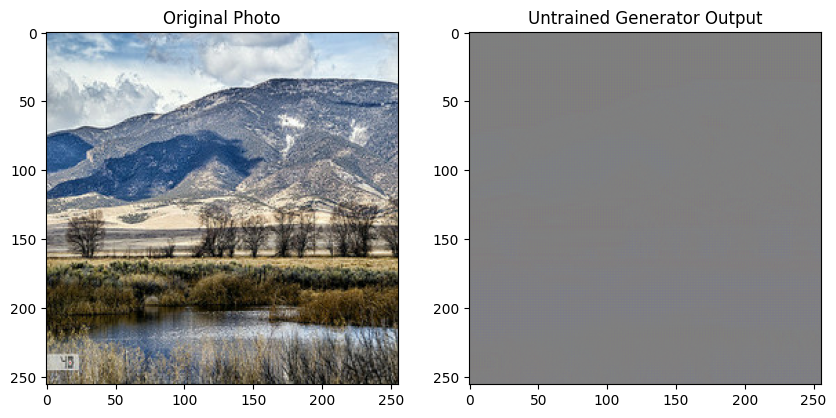

In [15]:
# Let's see the output of the untrained generator
toMonet = monetGen(photoEx)

# Plot it
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Original Photo')
plt.imshow(photoEx[0]*0.5 + 0.5)

plt.subplot(1,2,2)
plt.title('Untrained Generator Output')
plt.imshow(toMonet[0]*0.5 + 0.5)
plt.show()

# 4. Build the CycleGAN model
During the training step, this model transforms a photo into a Monet-esque painting and then back into a photo, sort of like those viral videos that used to translate Disney songs into another language and then back again. The difference in words/semantics between the original song and the twice-translated one was not only funny, but also showcased the cycle-consistency loss of the translation tool. We'll be using a similar idea here.

## 4.1 Define Loss Functions

### Discriminator Loss
This compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

### Generator Loss
The generator, in true adversarial fashion, wants to fool the discriminator into thinking the generated image is real-- and have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

### Cycle Loss
Unlike the doubly-translated Disney songs, we want our original photo and twice transformed photo to look pretty similar. We calculate the cycle consistency loss by finding the average of their difference.

### Identity Loss
The identity loss compares the image with its corresponding generator (i.e. a photo with the photo generator, or Monet with the Monet generator). If given a photo as input, we want the generator to create the same image. The identity loss compares the original image with the output of the generator.

In [16]:
with strategy.scope():
    # The discriminator loss function
    def discriminatorLoss(real,generated):
        realLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                    reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)

        genLoss = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                    reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)

        discLoss = realLoss + genLoss
        return discLoss*0.5

    def generatorLoss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True,
                     reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

    def cycleLoss(real,cycled,LAMBDA):
        loss = tf.reduce_mean(tf.abs(real - cycled))
        return LAMBDA*loss

    def identityLoss(real,same,LAMBDA):
        loss = tf.reduce_mean(tf.abs(real-same))
        return LAMBDA*loss*0.5

## 4.2 Define the CycleGAN class.
We're making a subclass of keras.Model here so we can use the built-in fit() function later. 

In [17]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monetGen,
        photoGen,
        monetDiscrim,
        photoDiscrim,
        lambdaCycle = 10,
    ):
        super().__init__()
        self.mGen = monetGen
        self.pGen = photoGen
        self.mDisc = monetDiscrim
        self.pDisc = photoDiscrim
        self.lambdaCycle = lambdaCycle

    def compile(
        self,
        mGenOptimizer,
        pGenOptimizer,
        mDiscOptimizer,
        pDiscOptimizer,
        genLossFn,
        discLossFn,
        cycleLossFn,
        identityLossFn,
    ):
        super().compile()
        self.mGenOptimizer = mGenOptimizer
        self.pGenOptimizer = pGenOptimizer
        self.mDiscOptimizer = mDiscOptimizer
        self.pDiscOptimizer = pDiscOptimizer
        self.genLossFn = genLossFn
        self.discLossFn = discLossFn
        self.cycleLossFn = cycleLossFn
        self.identityLossFn = identityLossFn

    def train_step(self,batchData):
        realMonet, realPhoto = batchData

        with tf.GradientTape(persistent=True) as tape:
            # Photo --> Monet --> Photo
            fakeMonet = self.mGen(realPhoto,training=True)
            cycledPhoto = self.pGen(fakeMonet,training=True)

            # Monet --> Photo --> Monet
            fakePhoto = self.pGen(realMonet,training=True)
            cycledMonet = self.mGen(fakePhoto,training=True)

            # Generate itself
            sameMonet = self.mGen(realMonet,training=True)
            samePhoto = self.pGen(realPhoto,training=True)

            # Discriminator with real images
            discRealMonet = self.mDisc(realMonet,training=True)
            discRealPhoto = self.pDisc(realPhoto,training=True)

            # Discriminate with fake images
            discFakeMonet = self.mDisc(fakeMonet,training=True)
            discFakePhoto = self.pDisc(fakePhoto,training=True)

            # Evaluate generator loss
            mGenLoss = self.genLossFn(discFakeMonet)
            pGenLoss = self.genLossFn(discFakeMonet)

            # Evaluate total cycle consistency loss
            totalCycleLoss = self.cycleLossFn(realMonet,cycledMonet,self.lambdaCycle) +\
                             self.cycleLossFn(realPhoto,cycledPhoto,self.lambdaCycle)

            # Evaluate total generator loss
            totalMGenLoss = mGenLoss + totalCycleLoss +\
            self.identityLossFn(realMonet,sameMonet,self.lambdaCycle)

            totalPGenLoss = pGenLoss + totalCycleLoss +\
            self.identityLossFn(realPhoto,samePhoto,self.lambdaCycle)

            # Evaluate discriminator loss
            mDiscLoss = self.discLossFn(discRealMonet,discFakeMonet)
            pDiscLoss = self.discLossFn(discRealPhoto,discFakePhoto)

        # Calculate generator gradients
        mGenGrads = tape.gradient(totalMGenLoss,self.mGen.trainable_variables)
        pGenGrads = tape.gradient(totalPGenLoss,self.pGen.trainable_variables)

        # Calculate discriminator gradients
        mDiscGrads = tape.gradient(mDiscLoss,self.mDisc.trainable_variables)
        pDiscGrads = tape.gradient(pDiscLoss,self.pDisc.trainable_variables)

        # Apply gradients to the optimizer
        self.mGenOptimizer.apply_gradients(zip(mGenGrads,self.mGen.trainable_variables))
        self.pGenOptimizer.apply_gradients(zip(pGenGrads,self.pGen.trainable_variables))
        self.mDiscOptimizer.apply_gradients(zip(mDiscGrads,self.mDisc.trainable_variables))
        self.pDiscOptimizer.apply_gradients(zip(pDiscGrads,self.pDisc.trainable_variables))

        return {
            'monetGenLoss': tf.reduce_mean(totalMGenLoss),
            'photoGenLoss': tf.reduce_mean(totalPGenLoss),
            'monetDiscLoss': tf.reduce_mean(mDiscLoss),
            'photoDiscLoss': tf.reduce_mean(pDiscLoss)
        }

# 5. Train the Model

## 5.1 The Model from the Tutorial

For this model, I'm going to use the optimizer hyperparameters suggested by the tutorial:
* learning rate = 2e-4
* beta_1 = 0.5
* lambda cycle = 10

In [18]:
with strategy.scope():
    mGenOptimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
    pGenOptimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

    mDiscOptimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)
    pDiscOptimizer = tf.keras.optimizers.Adam(2e-4,beta_1=0.5)

    cycleModel = CycleGan(monetGen,photoGen,monetDiscrim,photoDiscrim)

    cycleModel.compile(
        mGenOptimizer = mGenOptimizer,
        pGenOptimizer = pGenOptimizer,
        mDiscOptimizer = mDiscOptimizer,
        pDiscOptimizer = pDiscOptimizer,
        genLossFn = generatorLoss,
        discLossFn = discriminatorLoss,
        cycleLossFn = cycleLoss,
        identityLossFn = identityLoss
    )

aintNoHollaBacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='monet_gen_loss',
        mode = 'min',
        patience = 6,
        restore_best_weights=True
    )    
]

In [19]:
with strategy.scope():
    hist = cycleModel.fit(
        tf.data.Dataset.zip((monetDat,photoDat)),
        epochs=20,
        callbacks = aintNoHollaBacks
    )

Epoch 1/20


I0000 00:00:1750278552.133159      69 service.cc:148] XLA service 0x7cb97c002130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750278552.134080      69 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750278586.351161      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 148s 148ms/step - monetDiscLoss: 0.6115 - monetGenLoss: 5.1621 - photoDiscLoss: 0.5977 - photoGenLoss: 5.2517
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monetDiscLoss: 0.6343 - monetGenLoss: 3.7010 - photoDiscLoss: 0.4979 - photoGenLoss: 3.6847
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monetDiscLoss: 0.6148 - monetGenLoss: 3.6188 - photoDiscLoss: 0.1126 - photoGenLoss: 3.6091
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monetDiscLoss: 0.6077 - monetGenLoss: 3.5451 - photoDiscLoss: 0.0858 - photoGenLoss: 3.5401
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monetDiscLoss: 0.6056 - monetGenLoss: 3.4033 - photoDiscLoss: 0.0621 - photoGenLoss: 3.4177
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monetDiscLoss: 0.5882 - monetGenLoss: 3.2758 - photoDiscLoss: 0.0444 - photoGenLoss: 3.2936
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - monetDiscLoss: 0.5907 - monetGenLoss: 3.1624 - photoDiscLos

# 6. Model Results/Evaluation

## 6.1 Evaluate training losses

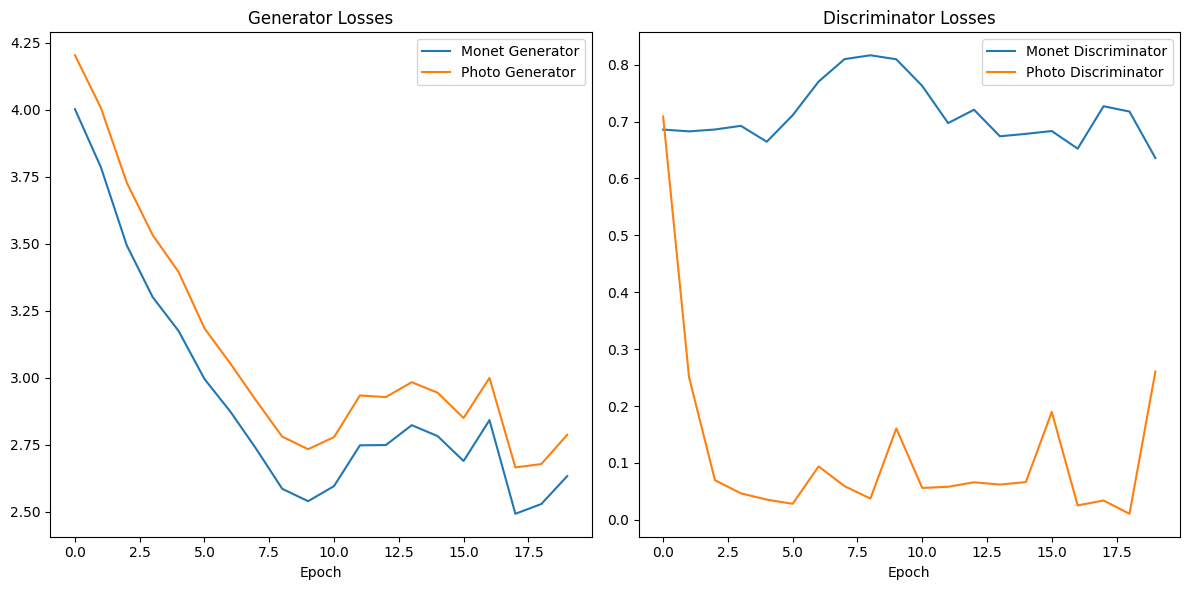

In [20]:
# Let's look at the generator and discriminator losses!
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(hist.history['monetGenLoss'],label='Monet Generator')
plt.plot(hist.history['photoGenLoss'],label='Photo Generator')
plt.title('Generator Losses')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['monetDiscLoss'],label='Monet Discriminator')
plt.plot(hist.history['photoDiscLoss'],label='Photo Discriminator')
plt.title('Discriminator Losses')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## 6.2 Display some of our Monet-ified photos


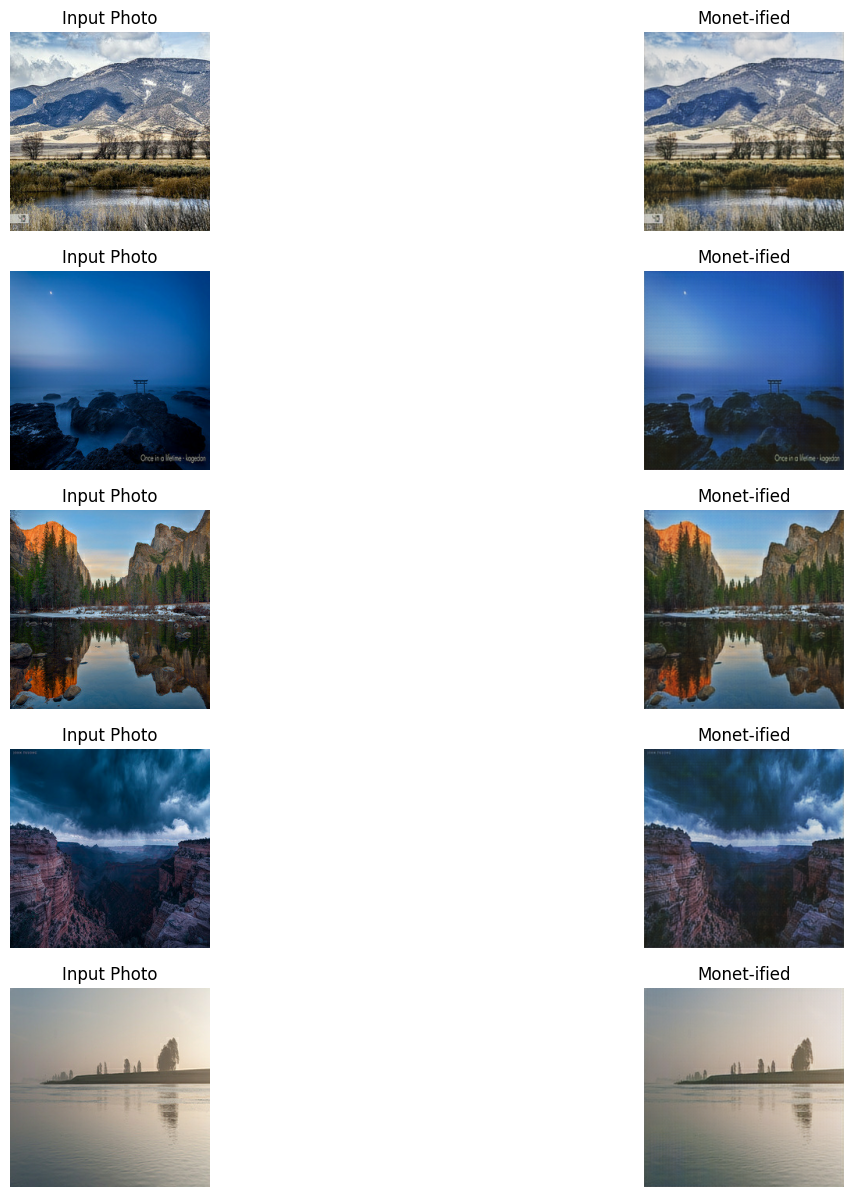

In [21]:
nImg = 5
fig, ax = plt.subplots(nImg,2,figsize=(15,15))

for ii, img in enumerate(photoDat.take(nImg)):
    pred = monetGen(img, training=False)[0].numpy()
    pred = (pred*127.5 + 127.5).astype(np.uint8)

    img = (img[0]*127.5 + 127.5).numpy().astype(np.uint8)

    ax[ii,0].imshow(img)
    ax[ii,0].set_title('Input Photo')
    ax[ii,0].axis('off')
    
    ax[ii,1].imshow(pred)
    ax[ii,1].set_title('Monet-ified')
    ax[ii,1].axis('off')

plt.show()
    

## Model Evaluation Conclusions

The results are... interesting, to say the least. I'm pretty sure a five-year-old could look at any of these and tell me it wasn't a painting, much less one by a famous artist, but I suppose they're not too bad overall. 

The program appears to 'Monet-ify' the photos by applying some blur or adding granularity to the images to imitate brushstrokes, and simplifying/discretizing the color palette of the images. As a result, one may say from afar that some of the images look like paintings. I guess that's good enough for the discriminator.

# 7. Generate Submission Files

In [22]:
! mkdir ../images

In [23]:
subFile = '/kaggle/working/images.zip'

with zipfile.ZipFile(subFile,'w') as zip_ref:
    count = 1
    for img in photoDat:
        if count % 1000 == 0:
            print(f'Processed {count} images')

        pred = monetGen(img, training=False)[0].numpy()
        pred = (pred*127.5 + 127.5).astype(np.uint8)

        im = PIL.Image.fromarray(pred)

        # Save directly to the zip
        imgByte = io.BytesIO()
        im.save(imgByte,format='JPEG')
        imgByte.seek(0)

        zip_ref.writestr(f"{count}.jpg", imgByte.getvalue())

        count+=1

Processed 1000 images
Processed 2000 images
Processed 3000 images
Processed 4000 images
Processed 5000 images
Processed 6000 images
Processed 7000 images


# 8. Overall Thoughts & Conclusions

In this project, we implemented a CycleGAN model to generate Monet-esque 'paintings' from input photos. The model was successfully able to balance its generative and discriminatory nature to produce these forgeries, which aren't the best but honestly not bad for the time it took to make them.

For future work, I'd definitely like to look into the training time for this model (although I suspect part of the issue is simply that I do not have access to a more powerful computer) as well as tune some of the hyperparameters of the model for accuracy. Additionally, I wonder if pre-processing the images in some way could improve the model's generalization -- particularly, we could attempt to remove watermarks from some of the photos or randomly flip, resize, or recolor images from the Monets and photos.

# References:

These notebooks helped me get started:

[1] https://www.kaggle.com/code/carlosmatherson/monet-cyclegan

[2] https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial